
## Template for Operating SimXRD Data

This template illustrates the workflow for working with SimXRD data. A demo database containing only 5 data samples is provided here for illustration purposes.

### Files Included
- **demo.db**: A demo database containing 5 SimXRD data samples.
- **template**: The code workflow template.

### Prerequisites
Ensure you have the necessary package installed:
```bash
pip install ase
```

### Step 1: Reading the Data

In [26]:
from ase.db import connect

# Connect to the demo database
demodata = connect("./demo.db")

# Acquire the total number of data entries
total = demodata.count()
print(f'The demo.db contains {total} data entries.')

The demo.db contains 10 data entries.


### Step 2: Retrieving Information of the First Entry

In [28]:
# ASE uses 1-based indexing for data entries
_id = 1

# Retrieve atomic structure of the first entry
atom = demodata.get_atoms(id=_id)
print(f'The chemical formula of the first entry is: {atom.get_chemical_formula()}')

The chemical formula of the first entry is: MgMnPt2


### Step 3: Deriving the Associated Powder Diffraction Pattern

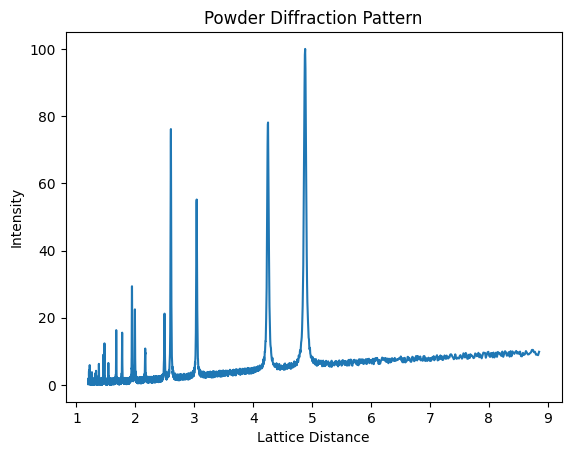

In [29]:
import matplotlib.pyplot as plt

# Extract lattice distance and intensity data
latt_dis = eval(demodata.get(id=_id)['latt_dis'])
intensity = eval(demodata.get(id=_id)['intensity'])

# Plot the diffraction pattern
plt.plot(latt_dis, intensity)
plt.xlabel('Lattice Distance')
plt.ylabel('Intensity')
plt.title('Powder Diffraction Pattern')
plt.show()

In [30]:
print(f'The diffraction lattice plane starts at {latt_dis[0]}, ends at {latt_dis[-1]}, with a step size of {latt_dis[1] - latt_dis[0]}.')

The diffraction lattice plane starts at 8.85302042684233, ends at 1.199447464570067, with a step size of -0.01764121602264268.


### Step 4: Retrieving Symmetry Information

In [31]:
# Extract symmetry information
tager = eval(demodata.get(id=_id)['tager'])

print(f'The crystal system is {tager[1]} and the space group is {tager[0]}.')
# The integer labels are defined in our paper: SimXRD4M

The crystal system is 7 and the space group is 1.


### Step 5: Displaying the Chemical Formula

In [32]:
chem_form = demodata.get(id=_id)['chem_form']
print(f'The chemical formula of the first entry is: {chem_form}')

The chemical formula of the first entry is: MgMnPt2


### Step 6: Printing Key Simulation Factors

In [33]:
# Extract key simulation parameters
key_param = eval(demodata.get(id=_id)['simulation_param'])

# Illustrate key simulation factors
print(f'The average grain size of the specimen is {key_param[0]} nm.')
print(f'The preferred orientation of the specimen is {key_param[1]}.')
print(f'The average atomic displacement is {key_param[2]} Å.')
print(f'The instrument zero shift is {key_param[3]} degrees.')

The average grain size of the specimen is 11.50535395136602 nm.
The preferred orientation of the specimen is [0.07108733888389587, 0.3234549738722757].
The average atomic displacement is 0.15859275809374668 Å.
The instrument zero shift is 0.7712741582169043 degrees.


## Generating Other Powder Diffraction Patterns

We also provide a simulation toolkit to generate powder diffraction patterns based on crystal data. The crystal data, retrieved from databases like the Materials Project, should be saved in ASE format to use this toolkit. 

For more details, refer to the simulator [here](https://huggingface.co/AI4Spectro/simulator).

## Applying the Training Framework

Clone our benchmark framework from the following repository to train your model:

```bash
git clone https://github.com/compasszzn/XRDBench
```

Step1 The dataset class for loading the data

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import ase.db
import json

class ASEDataset(Dataset):
    def __init__(self, db_paths,encode_element=False):
        ### if you want to use the element information, you can set encode_element to True
        with open('./CGCNN_atom_emb.json' , 'r') as file:
            self.cgcnn_emb = json.load(file)
        self.db_paths = db_paths
        self.encode_element = encode_element
        print(db_paths)
        self.dbs = [ase.db.connect(db_path) for db_path in db_paths]
        print("Loaded data from:", db_paths)

    def __len__(self):
        total_length = sum(len(db) for db in self.dbs)
        return total_length

    def __getitem__(self, idx):
        
        cumulative_length = 0
        for i, db in enumerate(self.dbs):
            if idx < cumulative_length + len(db):
                # Adjust the index to the range of the current database
                adjusted_idx = idx - cumulative_length
                row = db.get(adjusted_idx + 1)  # ASE db indexing starts from 1
                if self.encode_element:
                    atoms = row.toatoms()
                    element = atoms.get_chemical_symbols()
                    element_encode = self.symbol_to_atomic_number(element)
                    element_value = []
                    for code in element_encode:
                        value = self.cgcnn_emb[str(code)]
                        element_value.append(value)
                    element_value=torch.mean(torch.tensor(element_value, dtype=torch.float32),dim=0)
                # Extract relevant data from the row
                # latt_dis = eval(getattr(row, 'latt_dis'))
                intensity = eval(getattr(row, 'intensity'))
                spg = eval(getattr(row, 'tager'))[0]
                crysystem = eval(getattr(row, 'tager'))[1]

                # Convert to tensors
                # tensor_latt_dis = torch.tensor(latt_dis, dtype=torch.float32)
                tensor_intensity = torch.tensor(intensity, dtype=torch.float32)
                tensor_spg = torch.tensor(spg, dtype=torch.int64)
                tensor_crysystem = torch.tensor(crysystem, dtype=torch.int64)
                if self.encode_element:
                    return {
                        # 'latt_dis': tensor_latt_dis,
                        'intensity': tensor_intensity,
                        'spg': tensor_spg,
                        'crysystem': tensor_crysystem,
                        'element': element_value
                    }
                else:
                    return {
                        # 'latt_dis': tensor_latt_dis,
                        'intensity': tensor_intensity,
                        'spg': tensor_spg,
                        'crysystem': tensor_crysystem,
                        'element': torch.tensor([])
                    }              
            cumulative_length += len(db)

    def symbol_to_atomic_number(self,symbol_list):
        # Mapping of element symbols to atomic numbers
        atomic_numbers = {
            'H': 1, 'He': 2, 'Li': 3, 'Be': 4, 'B': 5,
            'C': 6, 'N': 7, 'O': 8, 'F': 9, 'Ne': 10,
            'Na': 11, 'Mg': 12, 'Al': 13, 'Si': 14, 'P': 15,
            'S': 16, 'Cl': 17, 'Ar': 18, 'K': 19, 'Ca': 20,
            'Sc': 21, 'Ti': 22, 'V': 23, 'Cr': 24, 'Mn': 25,
            'Fe': 26, 'Co': 27, 'Ni': 28, 'Cu': 29, 'Zn': 30,
            'Ga': 31, 'Ge': 32, 'As': 33, 'Se': 34, 'Br': 35,
            'Kr': 36, 'Rb': 37, 'Sr': 38, 'Y': 39, 'Zr': 40,
            'Nb': 41, 'Mo': 42, 'Tc': 43, 'Ru': 44, 'Rh': 45,
            'Pd': 46, 'Ag': 47, 'Cd': 48, 'In': 49, 'Sn': 50,
            'Sb': 51, 'Te': 52, 'I': 53, 'Xe': 54, 'Cs': 55,
            'Ba': 56, 'La': 57, 'Ce': 58, 'Pr': 59, 'Nd': 60,
            'Pm': 61, 'Sm': 62, 'Eu': 63, 'Gd': 64, 'Tb': 65,
            'Dy': 66, 'Ho': 67, 'Er': 68, 'Tm': 69, 'Yb': 70,
            'Lu': 71, 'Hf': 72, 'Ta': 73, 'W': 74, 'Re': 75,
            'Os': 76, 'Ir': 77, 'Pt': 78, 'Au': 79, 'Hg': 80,
            'Tl': 81, 'Pb': 82, 'Bi': 83, 'Po': 84, 'At': 85,
            'Rn': 86, 'Fr': 87, 'Ra': 88, 'Ac': 89, 'Th': 90,
            'Pa': 91, 'U': 92, 'Np': 93, 'Pu': 94, 'Am': 95,
            'Cm': 96, 'Bk': 97, 'Cf': 98, 'Es': 99, 'Fm': 100,
            'Md': 101, 'No': 102, 'Lr': 103, 'Rf': 104, 'Db': 105,
            'Sg': 106, 'Bh': 107, 'Hs': 108, 'Mt': 109, 'Ds': 110,
            'Rg': 111, 'Cn': 112, 'Nh': 113, 'Fl': 114, 'Mc': 115,
            'Lv': 116, 'Ts': 117, 'Og': 118
        }
        
        atomic_number_list = []
        for symbol in symbol_list:
            if symbol in atomic_numbers:
                atomic_number_list.append(atomic_numbers[symbol])
            else:
                atomic_number_list.append(0) 
        
        return atomic_number_list

Step2:Load the dataset

In [2]:
import os
datapath='/data/zzn/xrdsim'

train_dataset = ASEDataset([os.path.join(datapath, 'train_1/binxrd.db')],encode_element=False)
# If you want to load more training data, please refer to the code below.
# train_dataset = ASEDataset([os.path.join(datapath, 'train_1/binxrd.db'),os.path.join(datapath, 'train_2/binxrd.db')],encode_element=False)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=32)

['/data/zzn/xrdsim/train_1/binxrd.db']
Loaded data from: ['/data/zzn/xrdsim/train_1/binxrd.db']


Example of the train dataset

In [3]:
idx=0
train_dataset[0]
# 'spg' refers to the the classification of the space groups (in 1-230)
# 'crysystem' refers to the classification of the crystal system (in 1-7)

{'intensity': tensor([ 9.9964, 10.1384,  9.2186,  ...,  1.0521,  0.9492,  2.0920]),
 'spg': tensor(221),
 'crysystem': tensor(1),
 'element': tensor([])}

Step3:Build a bidirectional GRU Model for crystal system classification

In [4]:
import torch.nn as nn
import torch.nn.functional as F

class BiGRU(nn.Module):
    def __init__(self):
        super(BiGRU, self).__init__()
        self.hidden_size = 64
        self.num_layers = 4
        self.gru = nn.GRU(1, self.hidden_size, self.num_layers, batch_first=True, bidirectional=True)


        self.fc = nn.Linear(self.hidden_size*2, 7)## 7 class

    def forward(self, x):

        x = x.squeeze(1).unsqueeze(-1)
        out, _ = self.gru(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out

Step4:Training a model for one epoch

In [5]:
import torch.optim as optim
device = torch.device('cuda:0')## Use GPU the train the model
all_labels = []
all_predicted = []
model=BiGRU().to(device)## Move the model to the GPU
optimizer = optim.Adam(model.parameters(), lr=0.00025)## Perform gradient descent using the Adam optimizer
criterion = nn.CrossEntropyLoss()

In [6]:
from tqdm import tqdm
for batch_index, data in enumerate(tqdm(train_loader)):
    intensity = data['intensity'].to(device)##shape:(batch size,3501)
    crysystem_labels = data['crysystem'].to(device)##shape:(batch size)
    intensity = intensity.unsqueeze(1)##shape:(batch size,3501)->(batch size,1,3501)
    labels=crysystem_labels-1 ##change the label from 1-7 to 0-6
    batch_size=intensity.shape[0]
    optimizer.zero_grad()
    outputs = model(intensity)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    _, predicted = torch.max(outputs, 1)
    all_labels.extend(labels.cpu().numpy())
    all_predicted.extend(predicted.cpu().numpy())

100%|██████████| 4671/4671 [07:27<00:00, 10.43it/s]


Step5:Evaluate the performance by sklearn

In [7]:
from sklearn.metrics import f1_score,precision_score,recall_score,accuracy_score
accuracy = accuracy_score(all_labels, all_predicted)
macro_f1 = f1_score(all_labels, all_predicted, average='macro')
macro_precision = precision_score(all_labels, all_predicted, average='macro')
macro_recall = recall_score(all_labels, all_predicted, average='macro')

/home/zinanzheng/anaconda3/envs/xrdbench/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [8]:
print(f'The accuracy is {accuracy}.')
print(f'The macro f1 score is {macro_f1}.')
print(f'The macro precision is {macro_precision}.')
print(f'The macro recall is {macro_recall}.')

The accuracy is 0.48595204442623086.
The macro f1 score is 0.30534830580898437.
The macro precision is 0.3645366200167888.
The macro recall is 0.30931192575132.
